#### VARIABLES

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
basepath = "dades_tfg/data"
demographics = pd.read_csv(os.path.join(basepath, "demographics.csv"))
demographics_N = pd.read_csv(os.path.join(basepath, "demographics_N.csv"))
nodes = pd.read_csv(os.path.join(basepath, "nodes.csv"))
basepath_FA = os.path.join(basepath, "FA")
basepath_GM = os.path.join(basepath, "GM")
basepath_RS = os.path.join(basepath, "RS")

In [4]:
filenames = ["{:04d}.csv".format(x) for x in demographics["id"]]

In [5]:
data_FA = np.zeros(shape=(len(filenames), 76, 76))
data_GM = np.zeros(shape=(len(filenames), 76, 76))
data_RS = np.zeros(shape=(len(filenames), 76, 76))

In [6]:
for i, filename in enumerate(filenames):
    df_FA = pd.read_csv(os.path.join(basepath_FA, filename), header=None)
    data_FA[i,:,:] = df_FA.values
    
    df_GM = pd.read_csv(os.path.join(basepath_GM, filename), header=None)
    data_GM[i,:,:] = df_GM.values
    
    df_RS = pd.read_csv(os.path.join(basepath_RS, filename), header=None)
    data_RS[i,:,:] = df_RS.values

In [7]:
basepath_FA_N = "dades_tfg/data/Naples/DTI_networks"
basepath_GM_N = "dades_tfg/data/Naples/GM_networks"
basepath_RS_N = "dades_tfg/data/Naples/rsfmri_networks"

# Listar nombres de archivos CSV en cada carpeta
filenames_FA_N = sorted([f for f in os.listdir(basepath_FA_N) if f.endswith('.csv')])
filenames_GM_N = sorted([f for f in os.listdir(basepath_GM_N) if f.endswith('.csv')])
filenames_RS_N = sorted([f for f in os.listdir(basepath_RS_N) if f.endswith('.csv')])

In [8]:
# Inicializar arrays para almacenar los datos
data_FA_N = np.zeros((len(filenames_FA_N), 76, 76))  
data_GM_N = np.zeros((len(filenames_GM_N), 76, 76))
data_RS_N = np.zeros((len(filenames_RS_N), 76, 76))

In [9]:
# FA
for i, filename in enumerate(filenames_FA_N):
    df_FA_N = pd.read_csv(os.path.join(basepath_FA_N, filename), header=None)
    data_FA_N[i, :, :] = df_FA_N.values

#  GM
for i, filename in enumerate(filenames_GM_N):
    df_GM_N = pd.read_csv(os.path.join(basepath_GM_N, filename), header=None)
    data_GM_N[i, :, :] = df_GM_N.values

#  RS
for i, filename in enumerate(filenames_RS_N):
    df_RS_N = pd.read_csv(os.path.join(basepath_RS_N, filename), header=None)
    data_RS_N[i, :, :] = df_RS_N.values

In [10]:
num_samples_FA = len(data_FA)
num_samples_FA_N = len(data_FA_N)
num_samples_GM = len(data_FA)
num_samples_GM_N = len(data_FA_N)
num_samples_RS = len(data_FA)
num_samples_RS_N = len(data_FA_N)


data_FA_combined = np.zeros((num_samples_FA + num_samples_FA_N, 76, 76))  
data_FA_combined[:num_samples_FA, :, :] = data_FA
data_FA_combined[num_samples_FA:, :, :] = data_FA_N


data_GM_combined = np.zeros((num_samples_GM + num_samples_GM_N, 76, 76))  
data_GM_combined[:num_samples_GM, :, :] = data_GM
data_GM_combined[num_samples_GM:, :, :] = data_GM_N


data_RS_combined = np.zeros((num_samples_RS + num_samples_RS_N, 76, 76))  
data_RS_combined[:num_samples_RS, :, :] = data_RS
data_RS_combined[num_samples_RS:, :, :] = data_RS_N

In [11]:
demographics_N['mstype'] = demographics_N['mstype'].apply(lambda x: 0 if x == -1 else 1)

# Embeddings

In [12]:
from gensim.models.word2vec import Word2Vec
#!pip install node2vec
from node2vec import Node2Vec

### EMBEDDING POR REGIÓN CEREBRAL

In [13]:
regions_sequences = []

for i in range(len(data_FA_combined)):
    fa_str = f"fa_{data_FA_combined[i].mean():.4f}"
    gm_str = f"gm_{data_GM_combined[i].mean():.4f}"
    rs_str = f"rs_{data_RS_combined[i].mean():.4f}"
    regions_sequences.append([fa_str, gm_str, rs_str])

# Entrenar Word2Vec per les regions (fila -> regio, paraula -> característica)
region_model = Word2Vec(sentences=regions_sequences,
                        vector_size=10,  # Tamaño de los embeddings
                        window=3,        # Contexto de ventana
                        min_count=1,     # Mínima frecuencia
                        sg=1,            # Skip-gram
                        workers=4,       # Número de threads
                        seed=42)

# Verificar
word_to_check = 'fa_0.2402'
if word_to_check in region_model.wv:
    example_region_embedding = region_model.wv[word_to_check]
    print(f"Embedding for '{word_to_check}': {example_region_embedding}")
else:
    print(f"Key '{word_to_check}' not present in the vocabulary.")


Embedding for 'fa_0.2402': [ 0.05953992 -0.06183975 -0.00803814 -0.07406999  0.03762425 -0.00474666
 -0.03430344 -0.05558663  0.01260491  0.03407322]


### EMBEDDING POR INDIVIDUO

In [14]:
individual_sequences = []

num_regions_per_individual = 76

for i in range(0, data_FA_combined.shape[0], num_regions_per_individual):
    individual_data = []
    for j in range(num_regions_per_individual):
        idx = i + j
        if idx < data_FA_combined.shape[0]:
            fa_str = f"fa_{data_FA_combined[idx].mean():.4f}"
            gm_str = f"gm_{data_GM_combined[idx].mean():.4f}"
            rs_str = f"rs_{data_RS_combined[idx].mean():.4f}"
            individual_data.extend([fa_str, gm_str, rs_str])
    individual_sequences.append(individual_data)

#document -> 1 individu embedding x individu
individual_model = Word2Vec(sentences=individual_sequences,
                            vector_size=50,
                            window=5,
                            min_count=1,
                            sg=1,
                            workers=4,
                            seed=42)

# Verificar
example_individual_embedding = individual_model.wv['fa_0.2402']
print(example_individual_embedding)


[ 0.00113606 -0.01888139 -0.00772895 -0.00244514  0.01910514  0.02018554
 -0.01384227  0.01609786 -0.0171045   0.01069989  0.01315454  0.01580461
 -0.01115625  0.01704938 -0.01540964  0.00076591 -0.00086626 -0.00786031
 -0.01999719  0.01112008 -0.00636248  0.00671529 -0.00403518 -0.00518628
  0.01562859 -0.0161751   0.0092443   0.01025486 -0.00535387 -0.01025156
 -0.01987389  0.01697585  0.01776912 -0.01018531 -0.01909557 -0.01521568
 -0.01727444  0.01202455  0.01641897 -0.01382851  0.00974878 -0.01204344
 -0.0045702   0.00311581  0.00918622  0.01478828 -0.01842475 -0.01187794
 -0.00891993 -0.00797611]


### RANDOMWALK Y DEEPWALK

In [15]:
import networkx as nx

In [16]:
def calculate_threshold(matrix):
    weights = matrix.values.flatten()
    mean_weight = weights.mean()
    std_weight = weights.std()
    median_weight = np.median(weights)
    threshold = mean_weight + std_weight  # media + 2 * std # mirar-ho amb la median i tornar mirar la FA
    return threshold

def create_graph_with_threshold(adj_matrix, nodes, threshold):
    G = nx.Graph()
    for index, row in nodes.iterrows():
        G.add_node(row['region_id'], name=row['region_name'])
    for i in range(adj_matrix.shape[0]):
        for j in range(i + 1, adj_matrix.shape[1]):
            if adj_matrix.iloc[i, j] > threshold:  # mayor q threshold
                G.add_edge(i+1, j+1, weight=adj_matrix.iloc[i, j])
    return G

In [17]:
graphs_FA = []

for i in range(data_FA_combined.shape[0]):
    print(f"Loading data_FA_combined[{i}]")
    adj_matrix = pd.DataFrame(data_FA_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_FA = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_FA.number_of_nodes()} nodos, {G_FA.number_of_edges()} aristas")

    graphs_FA.append(G_FA)

Loading data_FA_combined[0]
   Threshold = 0.4428
Grafo creado para muestra 0: 76 nodos, 505 aristas
Loading data_FA_combined[1]
   Threshold = 0.4126
Grafo creado para muestra 1: 76 nodos, 439 aristas
Loading data_FA_combined[2]
   Threshold = 0.4698
Grafo creado para muestra 2: 76 nodos, 497 aristas
Loading data_FA_combined[3]
   Threshold = 0.4459
Grafo creado para muestra 3: 76 nodos, 469 aristas
Loading data_FA_combined[4]
   Threshold = 0.4144
Grafo creado para muestra 4: 76 nodos, 476 aristas
Loading data_FA_combined[5]
   Threshold = 0.4652
Grafo creado para muestra 5: 76 nodos, 437 aristas
Loading data_FA_combined[6]
   Threshold = 0.4134
Grafo creado para muestra 6: 76 nodos, 504 aristas
Loading data_FA_combined[7]
   Threshold = 0.4109
Grafo creado para muestra 7: 76 nodos, 437 aristas
Loading data_FA_combined[8]
   Threshold = 0.4051
Grafo creado para muestra 8: 76 nodos, 444 aristas
Loading data_FA_combined[9]
   Threshold = 0.4399
Grafo creado para muestra 9: 76 nodos, 44

   Threshold = 0.4568
Grafo creado para muestra 80: 76 nodos, 466 aristas
Loading data_FA_combined[81]
   Threshold = 0.5079
Grafo creado para muestra 81: 76 nodos, 443 aristas
Loading data_FA_combined[82]
   Threshold = 0.4786
Grafo creado para muestra 82: 76 nodos, 442 aristas
Loading data_FA_combined[83]
   Threshold = 0.4587
Grafo creado para muestra 83: 76 nodos, 469 aristas
Loading data_FA_combined[84]
   Threshold = 0.4690
Grafo creado para muestra 84: 76 nodos, 438 aristas
Loading data_FA_combined[85]
   Threshold = 0.4657
Grafo creado para muestra 85: 76 nodos, 517 aristas
Loading data_FA_combined[86]
   Threshold = 0.4486
Grafo creado para muestra 86: 76 nodos, 460 aristas
Loading data_FA_combined[87]
   Threshold = 0.4856
Grafo creado para muestra 87: 76 nodos, 461 aristas
Loading data_FA_combined[88]
   Threshold = 0.4881
Grafo creado para muestra 88: 76 nodos, 438 aristas
Loading data_FA_combined[89]
   Threshold = 0.4466
Grafo creado para muestra 89: 76 nodos, 444 aristas

   Threshold = 0.4668
Grafo creado para muestra 160: 76 nodos, 511 aristas
Loading data_FA_combined[161]
   Threshold = 0.4809
Grafo creado para muestra 161: 76 nodos, 440 aristas
Loading data_FA_combined[162]
   Threshold = 0.4965
Grafo creado para muestra 162: 76 nodos, 481 aristas
Loading data_FA_combined[163]
   Threshold = 0.4507
Grafo creado para muestra 163: 76 nodos, 591 aristas
Loading data_FA_combined[164]
   Threshold = 0.4883
Grafo creado para muestra 164: 76 nodos, 513 aristas
Loading data_FA_combined[165]
   Threshold = 0.4740
Grafo creado para muestra 165: 76 nodos, 232 aristas
Loading data_FA_combined[166]
   Threshold = 0.4864
Grafo creado para muestra 166: 76 nodos, 268 aristas
Loading data_FA_combined[167]
   Threshold = 0.5013
Grafo creado para muestra 167: 76 nodos, 303 aristas
Loading data_FA_combined[168]
   Threshold = 0.4655
Grafo creado para muestra 168: 76 nodos, 214 aristas
Loading data_FA_combined[169]
   Threshold = 0.5215
Grafo creado para muestra 169: 76

Grafo creado para muestra 239: 76 nodos, 177 aristas
Loading data_FA_combined[240]
   Threshold = 0.5147
Grafo creado para muestra 240: 76 nodos, 266 aristas
Loading data_FA_combined[241]
   Threshold = 0.5340
Grafo creado para muestra 241: 76 nodos, 177 aristas
Loading data_FA_combined[242]
   Threshold = 0.5147
Grafo creado para muestra 242: 76 nodos, 295 aristas
Loading data_FA_combined[243]
   Threshold = 0.5117
Grafo creado para muestra 243: 76 nodos, 316 aristas
Loading data_FA_combined[244]
   Threshold = 0.5223
Grafo creado para muestra 244: 76 nodos, 263 aristas
Loading data_FA_combined[245]
   Threshold = 0.5229
Grafo creado para muestra 245: 76 nodos, 240 aristas
Loading data_FA_combined[246]
   Threshold = 0.5553
Grafo creado para muestra 246: 76 nodos, 215 aristas
Loading data_FA_combined[247]
   Threshold = 0.5210
Grafo creado para muestra 247: 76 nodos, 266 aristas
Loading data_FA_combined[248]
   Threshold = 0.5186
Grafo creado para muestra 248: 76 nodos, 223 aristas
Lo

In [18]:
import random
num_walks = 10  # Número de caminatas por nodo
walk_length = 10  # Longitud de cada caminata

def random_walk(graph, start_node, walk_length):
    walk = [start_node]
    while len(walk) < walk_length:
        neighbors = list(graph.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = random.choice(neighbors)
            walk.append(next_node)
        else:
            break
    return walk

models_fa = []


for G_fa in graphs_FA:
    walks_fa = []

    for node in G_fa.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_fa, start_node=node, walk_length=walk_length)
            walks_fa.append(walk)

    walks_fa = [[str(node) for node in walk] for walk in walks_fa]
    model_fa = Word2Vec(walks_fa, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_fa.append(model_fa)


In [19]:
graphs_GM = []

for i in range(data_GM_combined.shape[0]):
    print(f"Loading data_GM_combined[{i}]")
    adj_matrix = pd.DataFrame(data_GM_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_GM = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_GM.number_of_nodes()} nodos, {G_GM.number_of_edges()} aristas")

    
    graphs_GM.append(G_GM)

Loading data_GM_combined[0]
   Threshold = 0.1390
Grafo creado para muestra 0: 76 nodos, 310 aristas
Loading data_GM_combined[1]
   Threshold = 0.1418
Grafo creado para muestra 1: 76 nodos, 315 aristas
Loading data_GM_combined[2]
   Threshold = 0.1779
Grafo creado para muestra 2: 76 nodos, 331 aristas
Loading data_GM_combined[3]
   Threshold = 0.1624
Grafo creado para muestra 3: 76 nodos, 332 aristas
Loading data_GM_combined[4]
   Threshold = 0.1477
Grafo creado para muestra 4: 76 nodos, 319 aristas
Loading data_GM_combined[5]
   Threshold = 0.1489
Grafo creado para muestra 5: 76 nodos, 319 aristas
Loading data_GM_combined[6]
   Threshold = 0.1440
Grafo creado para muestra 6: 76 nodos, 321 aristas
Loading data_GM_combined[7]
   Threshold = 0.1464
Grafo creado para muestra 7: 76 nodos, 331 aristas
Loading data_GM_combined[8]
   Threshold = 0.1402
Grafo creado para muestra 8: 76 nodos, 325 aristas
Loading data_GM_combined[9]
   Threshold = 0.1527
Grafo creado para muestra 9: 76 nodos, 32

Grafo creado para muestra 81: 76 nodos, 334 aristas
Loading data_GM_combined[82]
   Threshold = 0.1563
Grafo creado para muestra 82: 76 nodos, 324 aristas
Loading data_GM_combined[83]
   Threshold = 0.1845
Grafo creado para muestra 83: 76 nodos, 328 aristas
Loading data_GM_combined[84]
   Threshold = 0.1568
Grafo creado para muestra 84: 76 nodos, 332 aristas
Loading data_GM_combined[85]
   Threshold = 0.1241
Grafo creado para muestra 85: 76 nodos, 303 aristas
Loading data_GM_combined[86]
   Threshold = 0.1683
Grafo creado para muestra 86: 76 nodos, 329 aristas
Loading data_GM_combined[87]
   Threshold = 0.1587
Grafo creado para muestra 87: 76 nodos, 314 aristas
Loading data_GM_combined[88]
   Threshold = 0.1488
Grafo creado para muestra 88: 76 nodos, 327 aristas
Loading data_GM_combined[89]
   Threshold = 0.1660
Grafo creado para muestra 89: 76 nodos, 350 aristas
Loading data_GM_combined[90]
   Threshold = 0.1499
Grafo creado para muestra 90: 76 nodos, 314 aristas
Loading data_GM_combi

   Threshold = 0.1460
Grafo creado para muestra 162: 76 nodos, 314 aristas
Loading data_GM_combined[163]
   Threshold = 0.1607
Grafo creado para muestra 163: 76 nodos, 336 aristas
Loading data_GM_combined[164]
   Threshold = 0.1499
Grafo creado para muestra 164: 76 nodos, 310 aristas
Loading data_GM_combined[165]
   Threshold = 0.6831
Grafo creado para muestra 165: 76 nodos, 11 aristas
Loading data_GM_combined[166]
   Threshold = 0.6736
Grafo creado para muestra 166: 76 nodos, 3 aristas
Loading data_GM_combined[167]
   Threshold = 0.6324
Grafo creado para muestra 167: 76 nodos, 352 aristas
Loading data_GM_combined[168]
   Threshold = 0.6231
Grafo creado para muestra 168: 76 nodos, 351 aristas
Loading data_GM_combined[169]
   Threshold = 0.6496
Grafo creado para muestra 169: 76 nodos, 51 aristas
Loading data_GM_combined[170]
   Threshold = 0.7035
Grafo creado para muestra 170: 76 nodos, 0 aristas
Loading data_GM_combined[171]
   Threshold = 0.6639
Grafo creado para muestra 171: 76 nodos

Grafo creado para muestra 243: 76 nodos, 0 aristas
Loading data_GM_combined[244]
   Threshold = 0.6986
Grafo creado para muestra 244: 76 nodos, 2 aristas
Loading data_GM_combined[245]
   Threshold = 0.6561
Grafo creado para muestra 245: 76 nodos, 0 aristas
Loading data_GM_combined[246]
   Threshold = 0.6819
Grafo creado para muestra 246: 76 nodos, 0 aristas
Loading data_GM_combined[247]
   Threshold = 0.6693
Grafo creado para muestra 247: 76 nodos, 2 aristas
Loading data_GM_combined[248]
   Threshold = 0.6453
Grafo creado para muestra 248: 76 nodos, 12 aristas
Loading data_GM_combined[249]
   Threshold = 0.6930
Grafo creado para muestra 249: 76 nodos, 1 aristas
Loading data_GM_combined[250]
   Threshold = 0.6877
Grafo creado para muestra 250: 76 nodos, 0 aristas
Loading data_GM_combined[251]
   Threshold = 0.6754
Grafo creado para muestra 251: 76 nodos, 2 aristas
Loading data_GM_combined[252]
   Threshold = 0.6522
Grafo creado para muestra 252: 76 nodos, 27 aristas
Loading data_GM_comb

In [20]:
models_GM = []

for G_GM in graphs_GM:
    walks_GM = []

    for node in G_GM.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_GM, start_node=node, walk_length=walk_length)
            walks_GM.append(walk)

    walks_GM = [[str(node) for node in walk] for walk in walks_GM]
    model_GM = Word2Vec(walks_GM, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_GM.append(model_GM)

In [21]:
graphs_RS = []

for i in range(data_RS_combined.shape[0]):
    print(f"Loading data_RS_combined[{i}]")
    adj_matrix = pd.DataFrame(data_RS_combined[i])
    threshold = calculate_threshold(adj_matrix)
    print(f"   Threshold = {threshold:.4f}")
    G_RS = create_graph_with_threshold(adj_matrix, nodes, threshold)
    print(f"Grafo creado para muestra {i}: {G_RS.number_of_nodes()} nodos, {G_RS.number_of_edges()} aristas")

    graphs_RS.append(G_RS)

Loading data_RS_combined[0]
   Threshold = 0.5150
Grafo creado para muestra 0: 76 nodos, 501 aristas
Loading data_RS_combined[1]
   Threshold = 0.4391
Grafo creado para muestra 1: 76 nodos, 495 aristas
Loading data_RS_combined[2]
   Threshold = 0.4281
Grafo creado para muestra 2: 76 nodos, 471 aristas
Loading data_RS_combined[3]
   Threshold = 0.5125
Grafo creado para muestra 3: 76 nodos, 530 aristas
Loading data_RS_combined[4]
   Threshold = 0.4063
Grafo creado para muestra 4: 76 nodos, 483 aristas
Loading data_RS_combined[5]
   Threshold = 0.3985
Grafo creado para muestra 5: 76 nodos, 449 aristas
Loading data_RS_combined[6]
   Threshold = 0.5568
Grafo creado para muestra 6: 76 nodos, 558 aristas
Loading data_RS_combined[7]
   Threshold = 0.5084
Grafo creado para muestra 7: 76 nodos, 504 aristas
Loading data_RS_combined[8]
   Threshold = 0.4038
Grafo creado para muestra 8: 76 nodos, 477 aristas
Loading data_RS_combined[9]
   Threshold = 0.4767
Grafo creado para muestra 9: 76 nodos, 48

   Threshold = 0.4979
Grafo creado para muestra 81: 76 nodos, 507 aristas
Loading data_RS_combined[82]
   Threshold = 0.4312
Grafo creado para muestra 82: 76 nodos, 452 aristas
Loading data_RS_combined[83]
   Threshold = 0.4530
Grafo creado para muestra 83: 76 nodos, 511 aristas
Loading data_RS_combined[84]
   Threshold = 0.4502
Grafo creado para muestra 84: 76 nodos, 492 aristas
Loading data_RS_combined[85]
   Threshold = 0.5590
Grafo creado para muestra 85: 76 nodos, 507 aristas
Loading data_RS_combined[86]
   Threshold = 0.5565
Grafo creado para muestra 86: 76 nodos, 536 aristas
Loading data_RS_combined[87]
   Threshold = 0.4259
Grafo creado para muestra 87: 76 nodos, 446 aristas
Loading data_RS_combined[88]
   Threshold = 0.5665
Grafo creado para muestra 88: 76 nodos, 541 aristas
Loading data_RS_combined[89]
   Threshold = 0.5809
Grafo creado para muestra 89: 76 nodos, 535 aristas
Loading data_RS_combined[90]
   Threshold = 0.6913
Grafo creado para muestra 90: 76 nodos, 545 aristas

Grafo creado para muestra 160: 76 nodos, 458 aristas
Loading data_RS_combined[161]
   Threshold = 0.4325
Grafo creado para muestra 161: 76 nodos, 477 aristas
Loading data_RS_combined[162]
   Threshold = 0.4630
Grafo creado para muestra 162: 76 nodos, 484 aristas
Loading data_RS_combined[163]
   Threshold = 0.5040
Grafo creado para muestra 163: 76 nodos, 539 aristas
Loading data_RS_combined[164]
   Threshold = 0.4296
Grafo creado para muestra 164: 76 nodos, 483 aristas
Loading data_RS_combined[165]
   Threshold = 0.3211
Grafo creado para muestra 165: 76 nodos, 355 aristas
Loading data_RS_combined[166]
   Threshold = 0.4059
Grafo creado para muestra 166: 76 nodos, 383 aristas
Loading data_RS_combined[167]
   Threshold = 0.5202
Grafo creado para muestra 167: 76 nodos, 415 aristas
Loading data_RS_combined[168]
   Threshold = 0.4138
Grafo creado para muestra 168: 76 nodos, 402 aristas
Loading data_RS_combined[169]
   Threshold = 0.4123
Grafo creado para muestra 169: 76 nodos, 380 aristas
Lo

Grafo creado para muestra 240: 76 nodos, 449 aristas
Loading data_RS_combined[241]
   Threshold = 0.3806
Grafo creado para muestra 241: 76 nodos, 374 aristas
Loading data_RS_combined[242]
   Threshold = 0.4320
Grafo creado para muestra 242: 76 nodos, 370 aristas
Loading data_RS_combined[243]
   Threshold = 0.4527
Grafo creado para muestra 243: 76 nodos, 421 aristas
Loading data_RS_combined[244]
   Threshold = 0.4206
Grafo creado para muestra 244: 76 nodos, 417 aristas
Loading data_RS_combined[245]
   Threshold = 0.4166
Grafo creado para muestra 245: 76 nodos, 425 aristas
Loading data_RS_combined[246]
   Threshold = 0.5021
Grafo creado para muestra 246: 76 nodos, 399 aristas
Loading data_RS_combined[247]
   Threshold = 0.3724
Grafo creado para muestra 247: 76 nodos, 369 aristas
Loading data_RS_combined[248]
   Threshold = 0.4705
Grafo creado para muestra 248: 76 nodos, 445 aristas
Loading data_RS_combined[249]
   Threshold = 0.4521
Grafo creado para muestra 249: 76 nodos, 431 aristas
Lo

In [22]:
models_RS = []

for G_RS in graphs_RS:
    walks_RS = []

    for node in G_RS.nodes():
        for _ in range(num_walks):
            walk = random_walk(G_RS, start_node=node, walk_length=walk_length)
            walks_RS.append(walk)

    walks_RS = [[str(node) for node in walk] for walk in walks_RS]
    model_RS = Word2Vec(walks_RS, vector_size=50, window=5, min_count=0, sg=1, workers=4)
    models_RS.append(model_RS)

### MODELS

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [24]:
embeddings = []
for model in models_fa:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [25]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89        34
           1       0.88      0.98      0.93        47

    accuracy                           0.91        81
   macro avg       0.93      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [26]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89        34
           1       0.88      0.98      0.93        47

    accuracy                           0.91        81
   macro avg       0.93      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [27]:
embeddings = []
for model in models_GM:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [28]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [29]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81



In [30]:
embeddings = []
for model in models_RS:
    embedding = np.mean([model.wv[str(node)] for node in model.wv.index_to_key], axis=0)  # Promediar los embeddings de los nodos
    embeddings.append(embedding)

X = np.array(embeddings)
y = np.array(demographics_N['mstype'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# SVM
svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Accuracy: 0.7037037037037037
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.56      0.61        34
           1       0.72      0.81      0.76        47

    accuracy                           0.70        81
   macro avg       0.70      0.68      0.69        81
weighted avg       0.70      0.70      0.70        81



In [32]:
# Regresión Logística
log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.7037037037037037
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.53      0.60        34
           1       0.71      0.83      0.76        47

    accuracy                           0.70        81
   macro avg       0.70      0.68      0.68        81
weighted avg       0.70      0.70      0.70        81



### AMB NODE2VEC

In [33]:
embeddings = []

for G_fa in graphs_FA:
    node2vec = Node2Vec(G_fa, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_fa = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_fa.wv[str(node)] for node in G_fa.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 480.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 417.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 408.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 524.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 340.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 582.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 409.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 526.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 551.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 447.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 550.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 507.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 369.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 535.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 480.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 431.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 389.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 697.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 269.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 377.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 534.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 623.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 454.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 232.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 375.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 509.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 517.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 487.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 375.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 350.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 654.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 409.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 534.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 481.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 479.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 366.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 399.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 407.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 650.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 494.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 387.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 333.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 323.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 483.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 621.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 524.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 544.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 375.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 545.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 384.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 189.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 526.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 349.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 678.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 502.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 593.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 562.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 422.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 386.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 356.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 568.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 545.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 403.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 475.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 354.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 395.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 341.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 343.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 534.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 483.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 390.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 480.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 180.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 579.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 423.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 495.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 358.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 454.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 345.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 376.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 474.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 295.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 400.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 315.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 596.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 381.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 467.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 461.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 423.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 388.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 489.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 317.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 359.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 440.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 389.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 348.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 200.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 392.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 334.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 390.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 390.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 359.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 575.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 388.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 392.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 568.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 393.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 462.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 339.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 368.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 556.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 423.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 441.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 323.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 404.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 579.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 185.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 362.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 446.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 540.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 415.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 720.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 839.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 499.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 712.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 994.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 763.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 484.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 453.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 354.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 446.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 699.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 565.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 249.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 498.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1078.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 776.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 887.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 699.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 728.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 789.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 782.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 603.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 664.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 700.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 973.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 669.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 691.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 707.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 821.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 866.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 226.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 844.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 650.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 552.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 679.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 643.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 828.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 739.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1004.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 720.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 875.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 598.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 755.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 499.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 411.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 559.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 915.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 668.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 505.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 547.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 609.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 627.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 478.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 830.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 618.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 628.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 909.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 885.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 233.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 846.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 832.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 762.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 611.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 619.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 643.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 656.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 568.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 714.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 796.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 738.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 660.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 821.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 699.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 698.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 761.03it/s]


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.8765432098765432
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        34
           1       0.86      0.94      0.90        47

    accuracy                           0.88        81
   macro avg       0.88      0.87      0.87        81
weighted avg       0.88      0.88      0.88        81

Logistic Regression Accuracy: 0.8888888888888888
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        34
           1       0.88      0.94      0.91        47

    accuracy                           0.89        81
   macro avg       0.89      0.88      0.88        81
weighted avg       0.89      0.89      0.89        81

SVM AUC-ROC: 0.9017521902377973
Logistic Regression AUC-ROC: 0.9080100125156445


In [35]:
embeddings = []

for G_GM in graphs_GM:
    node2vec = Node2Vec(G_GM, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_GM = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_GM.wv[str(node)] for node in G_GM.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 432.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 475.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 606.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 466.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 513.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 629.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 756.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 704.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 600.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 664.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 639.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 207.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 467.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 806.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 776.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 395.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 689.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 565.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 696.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 536.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 644.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 541.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 779.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 444.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 466.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 411.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 650.14it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 413.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 684.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 891.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 479.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 673.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 488.01it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 390.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 703.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 659.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 658.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 508.82it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 355.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 523.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 211.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 465.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 599.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 514.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 840.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 445.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 541.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 596.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 539.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 507.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 635.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 443.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 405.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 539.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 498.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 453.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 491.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 484.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 745.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 925.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 479.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 598.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 460.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 882.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 580.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 697.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 212.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 469.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 847.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 545.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 462.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 636.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 673.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 546.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 542.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 617.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 496.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 621.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 517.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 445.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 773.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 489.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 570.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 773.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 818.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 497.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 669.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 448.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 677.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 512.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 551.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 665.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 220.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 503.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 540.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 582.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 495.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 498.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 641.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 415.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 676.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 455.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 526.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 538.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 461.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 519.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 696.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 453.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 489.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 319.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 385.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 578.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 470.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 529.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 805.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 528.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 235.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 645.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 662.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 541.69it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 494.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 449.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 622.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 588.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 706.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 742.87it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 563.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 661.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 539.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3317.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5000.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 849.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 695.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2540.71it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 8382.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2557.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 50/50 [00:00<00:00, 10103.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2346.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1863.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1467.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3556.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3012.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 263.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2747.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1479.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1069.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 808.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3594.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2295.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2644.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2419.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2174.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1250.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4004.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1183.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1923.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3316.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1872.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1206.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1948.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2154.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2373.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3846.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 586.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 922.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1448.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1552.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2287.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3853.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6518.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2842.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3449.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 761.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 783.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2676.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1664.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1287.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1938.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1518.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 530.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4895.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3586.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1387.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2034.61it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2472.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2208.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5029.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 310.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4360.07it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1922.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4530.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1740.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3347.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6250.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3317.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3571.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1862.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 509.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3082.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2766.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4544.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3626.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1672.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 870.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 4166.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2892.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3856.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2671.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5689.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3871.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2510.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1562.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3846.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5576.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3748.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2074.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2850.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 863.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 5506.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3869.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 3081.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2992.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6249.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 2296.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1197.57it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1521.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1818.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 281.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 902.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 6252.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1348.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1699.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 1188.38it/s]


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)


y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)


y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.9135802469135802
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

Logistic Regression Accuracy: 0.9135802469135802
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.79      0.89        34
           1       0.87      1.00      0.93        47

    accuracy                           0.91        81
   macro avg       0.94      0.90      0.91        81
weighted avg       0.92      0.91      0.91        81

SVM AUC-ROC: 0.918648310387985
Logistic Regression AUC-ROC: 0.8754693366708386


In [37]:
embeddings = []

for G_RS in graphs_RS:
    node2vec = Node2Vec(G_RS, dimensions=25, walk_length=5, num_walks=50, workers=1, p=1, q=1)
    model_RS = node2vec.fit(window=5, min_count=1, sg=1)

    embedding = np.mean([model_RS.wv[str(node)] for node in G_RS.nodes()], axis=0)
    embeddings.append(embedding)

X = np.array(embeddings)

Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 472.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 466.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 322.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 522.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 692.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 349.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 448.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 601.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 332.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 389.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 376.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 537.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 429.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 699.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 511.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 362.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 476.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 361.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.10it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 417.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 381.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 464.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 362.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 490.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 527.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 521.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 418.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 178.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 445.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 637.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 576.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 462.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 562.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 462.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 355.98it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 504.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 349.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 328.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 328.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 596.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 680.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.99it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 589.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 500.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 363.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 356.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 510.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 325.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 380.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 724.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 634.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 413.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 423.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 646.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 332.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 401.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 503.68it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 529.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.00it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.17it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 435.13it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 177.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 365.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 697.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 394.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 655.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 423.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 398.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 413.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 354.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 397.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 434.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 403.29it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 565.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 506.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 368.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 668.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 616.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 519.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 358.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 475.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 449.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 451.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 417.63it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 434.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 403.36it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 613.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 596.58it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 182.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 442.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 490.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 456.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 492.74it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 374.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 395.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 403.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 470.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 377.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.70it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 734.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 418.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 705.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.89it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 398.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.50it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 459.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 648.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.73it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 462.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 530.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 492.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 626.09it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 419.46it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 151.37it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 746.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 479.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 513.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 481.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 573.53it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 410.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 375.24it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 553.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 555.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 577.59it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 471.51it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 441.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 329.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 539.23it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 304.94it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 441.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 430.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 311.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 561.34it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 592.28it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 598.40it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 434.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 553.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 686.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 550.05it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 427.35it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 191.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 463.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 549.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 516.91it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 619.16it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 424.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 578.79it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.43it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 378.21it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 450.22it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 364.18it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 417.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.80it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 758.41it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 584.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 523.86it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 543.60it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 546.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 520.11it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.27it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 396.42it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 677.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 419.93it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 574.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 493.06it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 390.47it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 375.04it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 476.31it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 675.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 632.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 510.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 590.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 458.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 708.78it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 367.49it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 478.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 531.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 571.32it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 421.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 422.44it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.97it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 498.15it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 515.90it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 505.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 620.96it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 469.81it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 594.83it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 153.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 595.55it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 350.30it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 757.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 501.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 448.52it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 420.19it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 428.77it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 481.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 499.38it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 493.08it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 329.95it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 554.02it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 548.25it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 468.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 699.26it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 475.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 615.39it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 567.65it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 691.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 479.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 680.85it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 494.66it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 604.84it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.75it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 532.54it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 438.20it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 552.67it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 534.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 448.72it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 528.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 602.45it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 477.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 373.33it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 452.64it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 434.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 666.56it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 533.48it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 471.88it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.12it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 439.03it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 414.92it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 331.62it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 624.76it/s]


Computing transition probabilities:   0%|          | 0/76 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████████████████████████████████████████████████| 50/50 [00:00<00:00, 426.92it/s]


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm_clf = SVC(probability=True, random_state=42)
svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

log_clf = LogisticRegression(random_state=42, max_iter=10000)
log_clf.fit(X_train, y_train)

y_pred_log = log_clf.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log))

y_proba_svm = svm_clf.predict_proba(X_test)[:, 1]
y_proba_log = log_clf.predict_proba(X_test)[:, 1]
print("SVM AUC-ROC:", roc_auc_score(y_test, y_proba_svm))
print("Logistic Regression AUC-ROC:", roc_auc_score(y_test, y_proba_log))

SVM Accuracy: 0.7530864197530864
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71        34
           1       0.79      0.79      0.79        47

    accuracy                           0.75        81
   macro avg       0.75      0.75      0.75        81
weighted avg       0.75      0.75      0.75        81

Logistic Regression Accuracy: 0.7407407407407407
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69        34
           1       0.77      0.79      0.78        47

    accuracy                           0.74        81
   macro avg       0.73      0.73      0.73        81
weighted avg       0.74      0.74      0.74        81

SVM AUC-ROC: 0.8028785982478097
Logistic Regression AUC-ROC: 0.8010012515644556


In [39]:
node_id_to_name = dict(zip(nodes['region_id'], nodes['region_name']))
print(node_id_to_name)

{1: 'ctx.lh.caudalanteriorcingulate', 2: 'ctx.lh.caudalmiddlefrontal', 3: 'ctx.lh.cuneus', 4: 'ctx.lh.entorhinal', 5: 'ctx.lh.fusiform', 6: 'ctx.lh.inferiorparietal', 7: 'ctx.lh.inferiortemporal', 8: 'ctx.lh.isthmuscingulate', 9: 'ctx.lh.lateraloccipital', 10: 'ctx.lh.lateralorbitofrontal', 11: 'ctx.lh.lingual', 12: 'ctx.lh.medialorbitofrontal', 13: 'ctx.lh.middletemporal', 14: 'ctx.lh.parahippocampal', 15: 'ctx.lh.paracentral', 16: 'ctx.lh.parsopercularis', 17: 'ctx.lh.parsorbitalis', 18: 'ctx.lh.parstriangularis', 19: 'ctx.lh.pericalcarine', 20: 'ctx.lh.postcentral', 21: 'ctx.lh.posteriorcingulate', 22: 'ctx.lh.precentral', 23: 'ctx.lh.precuneus', 24: 'ctx.lh.rostralanteriorcingulate', 25: 'ctx.lh.rostralmiddlefrontal', 26: 'ctx.lh.superiorfrontal', 27: 'ctx.lh.superiorparietal', 28: 'ctx.lh.superiortemporal', 29: 'ctx.lh.supramarginal', 30: 'ctx.lh.transversetemporal', 31: 'ctx.lh.insula', 32: 'left.thalamus', 33: 'left.caudate', 34: 'left.putamen', 35: 'left.pallidum', 36: 'left.hi

In [40]:
def recommend(node):
    similar_nodes = model_fa.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  # Convertir el id del nodo a nombre 
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.lh.pericalcarine: Similaridad = 0.99
Nodo ctx.lh.inferiortemporal: Similaridad = 0.99
Nodo ctx.rh.superiorparietal: Similaridad = 0.99
Nodo ctx.lh.superiorparietal: Similaridad = 0.99
Nodo ctx.rh.inferiortemporal: Similaridad = 0.99
Nodo ctx.rh.isthmuscingulate: Similaridad = 0.99
Nodo right.putamen: Similaridad = 0.99
Nodo ctx.lh.fusiform: Similaridad = 0.99
Nodo ctx.lh.parahippocampal: Similaridad = 0.99
Nodo ctx.lh.middletemporal: Similaridad = 0.99


In [41]:
def recommend(node):
    similar_nodes = model_GM.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.paracentral: Similaridad = 0.38
Nodo ctx.rh.rostralanteriorcingulate: Similaridad = 0.34
Nodo ctx.rh.transversetemporal: Similaridad = 0.32
Nodo ctx.rh.parstriangularis: Similaridad = 0.30
Nodo ctx.rh.lateraloccipital: Similaridad = 0.29
Nodo ctx.rh.caudalmiddlefrontal: Similaridad = 0.25
Nodo ctx.lh.rostralmiddlefrontal: Similaridad = 0.25
Nodo ctx.rh.middletemporal: Similaridad = 0.24
Nodo ctx.rh.insula: Similaridad = 0.21
Nodo ctx.rh.rostralmiddlefrontal: Similaridad = 0.17


In [42]:
def recommend(node):
    similar_nodes = model_RS.wv.most_similar(str(node))

    for node, similarity in similar_nodes:
        node_name = node_id_to_name[int(node)]  
        print(f"Nodo {node_name}: Similaridad = {similarity:.2f}")

recommend(3)

Nodo ctx.rh.pericalcarine: Similaridad = 1.00
Nodo ctx.lh.fusiform: Similaridad = 1.00
Nodo ctx.lh.lateraloccipital: Similaridad = 1.00
Nodo ctx.rh.cuneus: Similaridad = 1.00
Nodo ctx.lh.pericalcarine: Similaridad = 1.00
Nodo ctx.rh.lingual: Similaridad = 1.00
Nodo ctx.lh.lingual: Similaridad = 1.00
Nodo ctx.rh.lateraloccipital: Similaridad = 1.00
Nodo ctx.rh.fusiform: Similaridad = 0.99
Nodo ctx.rh.precuneus: Similaridad = 0.88


In [43]:
import matplotlib.pyplot as plt

In [44]:
G_namedd = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_namedd.add_node(node_name) 

for node_id in model_fa.wv.index_to_key:  
    for node1, similarity in model_fa.wv.most_similar(0, topn=75): #ITERAR SOBRE UNO CON MAXIMO DE TOPN
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[0]
            name2 = node_id_to_name[int(node1)]
            G_namedd.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_namedd.number_of_nodes()}")
print(f"Número de aristas: {G_namedd.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_namedd)  
nx.draw(G_namedd, pos, with_labels=True, node_size=5000, node_color="lightblue", font_size=10)
plt.show()

KeyError: 0

Número de nodos: 76
Número de aristas: 278


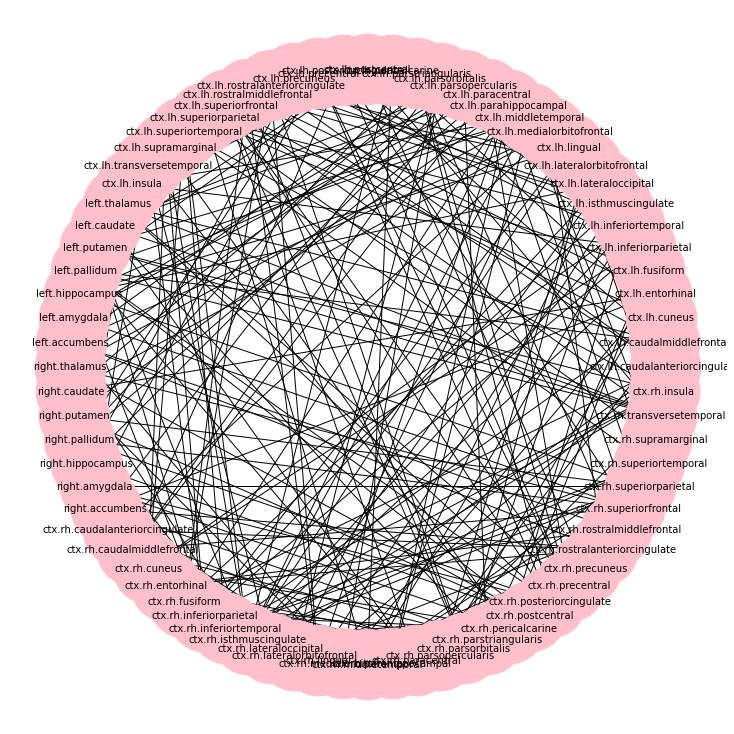

In [45]:
G_named_FA = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_FA.add_node(node_name)  

for node_id in model_fa.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_fa.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_FA.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_FA.number_of_nodes()}")
print(f"Número de aristas: {G_named_FA.number_of_edges()}")



plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_FA) 
nx.draw(G_named_FA, pos, with_labels=True, node_size=5000, node_color="pink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 276


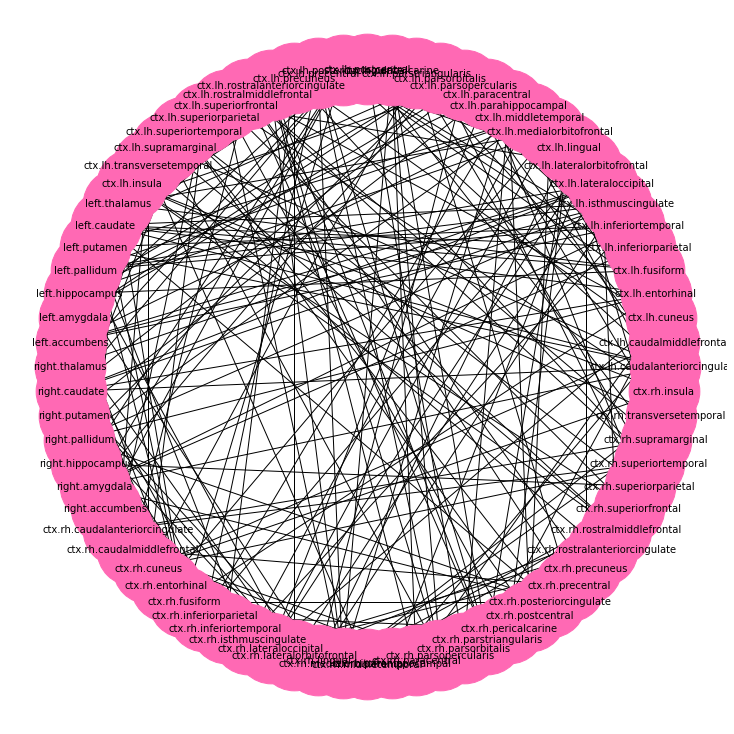

In [46]:
G_named_GM = nx.Graph()

for node_id, node_name in node_id_to_name.items():
    G_named_GM.add_node(node_name) 

for node_id in model_GM.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_GM.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_GM.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_GM.number_of_nodes()}")
print(f"Número de aristas: {G_named_GM.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_GM)  # Disposición de los nodos
nx.draw(G_named_GM, pos, with_labels=True, node_size=5000, node_color="hotpink", font_size=10)
plt.show()

Número de nodos: 76
Número de aristas: 267


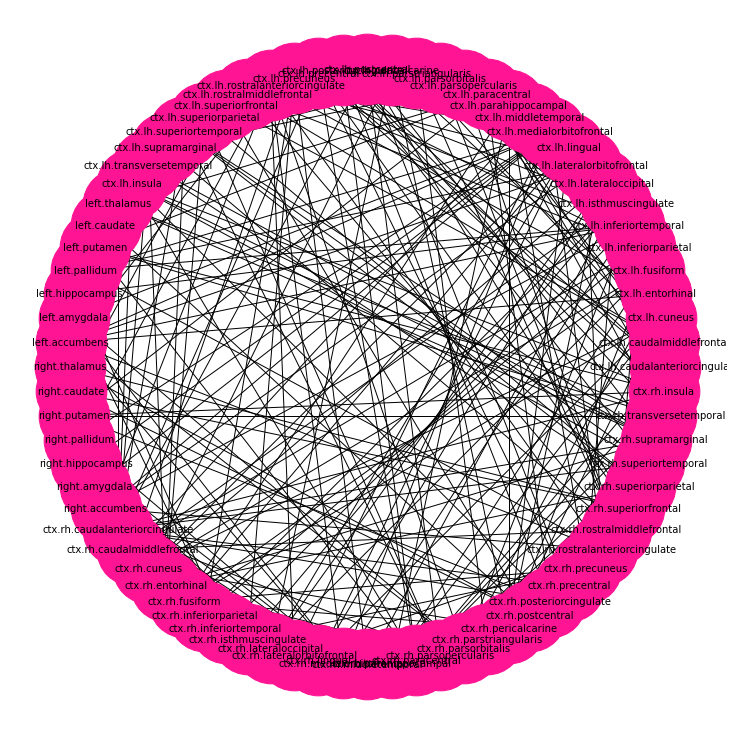

In [47]:
G_named_RS = nx.Graph()


for node_id, node_name in node_id_to_name.items():
    G_named_RS.add_node(node_name)  # Añadir el nodo usando su nombre

for node_id in model_RS.wv.index_to_key:  # Iterar sobre TOOODOOSSS los nodos en el modelo
    for node1, similarity in model_RS.wv.most_similar(node_id, topn=5):
        if int(node1) in node_id_to_name and int(node_id) in node_id_to_name:
            name1 = node_id_to_name[int(node_id)]
            name2 = node_id_to_name[int(node1)]
            G_named_RS.add_edge(name1, name2, weight=similarity)


print(f"Número de nodos: {G_named_RS.number_of_nodes()}")
print(f"Número de aristas: {G_named_RS.number_of_edges()}")


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(G_named_RS)  
nx.draw(G_named_RS, pos, with_labels=True, node_size=5000, node_color="deeppink", font_size=10)
plt.show()

In [49]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F


node_features_fa = []

for node in G_fa.nodes():
    node_features_fa.append(model_fa.wv[str(node)])

node_features_fa = np.array(node_features_fa)

data = Data()
data.x = torch.tensor(node_features_fa, dtype=torch.float)

In [50]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)  # Capa de convolución con 16 unidades
        self.conv2 = GCNConv(16, num_classes)        # Capa de convolución con tantas unidades como clases

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [51]:
torch.manual_seed(1)

# Supongamos que ya tienes el grafo G_fa y el modelo_fa para Node2Vec
node_features_fa = []

# Asegúrate de que los nodos sean cadenas antes de buscar en el modelo
for node in G_fa.nodes():
    node_key = str(node)  # Convertir a cadena
    if node_key in model_fa.wv:
        node_features_fa.append(model_fa.wv[node_key])
    else:
        print(f"Advertencia: Nodo {node} no tiene embedding en model_fa.wv")

# Convertir la lista de características a un numpy array
node_features_fa = np.array(node_features_fa)

# Crear un objeto Data de PyTorch Geometric
data = Data()
data.x = torch.tensor(node_features_fa, dtype=torch.float)

# Asegúrate de que los nodos estén numerados correctamente
G_fa = nx.convert_node_labels_to_integers(G_fa, first_label=0)
data.edge_index = torch.tensor(list(G_fa.edges), dtype=torch.long).t().contiguous()

# Filtrar índices fuera de rango (índices mayores o iguales a 76)
valid_mask = (data.edge_index < 76).all(dim=0)
data.edge_index = data.edge_index[:, valid_mask]

# Verificar el cambio
print(f"Máximo índice en edge_index después de filtrar: {torch.max(data.edge_index)}")
print(f"Nuevo tamaño de edge_index: {data.edge_index.shape}")

# Crear etiquetas de ejemplo para los nodos (esto debería ser ajustado según tu caso)
data.y = torch.tensor([0] * (len(data.x) // 2) + [1] * (len(data.x) // 2), dtype=torch.long)

# Crear máscaras de entrenamiento, validación y prueba
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[:int(0.6 * len(data.x))] = 1  # 60% para entrenamiento
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask[int(0.6 * len(data.x)):int(0.8 * len(data.x))] = 1  # 20% para validación
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask[int(0.8 * len(data.x)):] = 1  # 20% para prueba

# Verificar las máscaras
print(f"train_mask size: {data.train_mask.size()}")
print(f"val_mask size: {data.val_mask.size()}")
print(f"test_mask size: {data.test_mask.size()}")

# Definir el modelo GCN
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                     lr=0.001,
                                     weight_decay=5e-4)

        self.train()
        for epoch in range(epochs + 1):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true).item() / len(y_true)

# Crear el modelo GCN usando las características de los nodos que ya definiste
num_node_features = data.x.shape[1]  # Número de características por nodo
num_classes = torch.max(data.y).item() + 1  # Número de clases basado en las etiquetas

gcn = GCN(num_node_features, 16, num_classes)
print(gcn)

# Entrenar
gcn.fit(data, epochs=100)  # Prueba con 10 épocas primero

# Probar
acc = gcn.test(data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Máximo índice en edge_index después de filtrar: 75
Nuevo tamaño de edge_index: torch.Size([2, 286])
train_mask size: torch.Size([76])
val_mask size: torch.Size([76])
test_mask size: torch.Size([76])
GCN(
  (gcn1): GCNConv(25, 16)
  (gcn2): GCNConv(16, 2)
)
Epoch   0 | Train Loss: 0.634 | Train Acc: 84.44% | Val Loss: 0.96 | Val Acc: 20.00%
Epoch  20 | Train Loss: 0.556 | Train Acc: 84.44% | Val Loss: 1.83 | Val Acc: 0.00%
Epoch  40 | Train Loss: 0.540 | Train Acc: 84.44% | Val Loss: 2.44 | Val Acc: 0.00%
Epoch  60 | Train Loss: 0.535 | Train Acc: 84.44% | Val Loss: 2.53 | Val Acc: 0.00%
Epoch  80 | Train Loss: 0.529 | Train Acc: 84.44% | Val Loss: 2.45 | Val Acc: 0.00%
Epoch 100 | Train Loss: 0.523 | Train Acc: 84.44% | Val Loss: 2.36 | Val Acc: 0.00%

GCN test accuracy: 0.00%



In [52]:
print("Nodos en G_fa:", list(G_fa.nodes()))
print("Claves en model_fa.wv:", list(model_fa.wv.key_to_index.keys()))


Nodos en G_fa: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
Claves en model_fa.wv: ['72', '68', '60', '54', '3', '8', '23', '52', '19', '32', '48', '64', '9', '51', '58', '73', '27', '15', '29', '11', '74', '67', '34', '6', '7', '28', '22', '35', '76', '31', '5', '10', '62', '71', '13', '42', '41', '20', '26', '37', '21', '14', '50', '59', '36', '75', '53', '43', '47', '65', '39', '66', '30', '16', '1', '56', '2', '18', '24', '25', '33', '46', '17', '44', '63', '12', '57', '69', '49', '38', '55', '61', '70', '45', '4', '40']


In [53]:
missing_nodes = [node for node in G_fa.nodes() if str(node) not in model_fa.wv]
print(f"Nodos sin embeddings: {missing_nodes}")

Nodos sin embeddings: [0]


In [54]:
# Verificar si el nodo 0 está presente en cada grafo en graphs_RS
node_0_presence = {i: (0 in G_RS.nodes()) for i, G_RS in enumerate(graphs_RS)}

# Imprimir resultados
for i, presence in node_0_presence.items():
    print(f"Nodo 0 {'está presente' if presence else 'NO está presente'} en el grafo {i}")


Nodo 0 NO está presente en el grafo 0
Nodo 0 NO está presente en el grafo 1
Nodo 0 NO está presente en el grafo 2
Nodo 0 NO está presente en el grafo 3
Nodo 0 NO está presente en el grafo 4
Nodo 0 NO está presente en el grafo 5
Nodo 0 NO está presente en el grafo 6
Nodo 0 NO está presente en el grafo 7
Nodo 0 NO está presente en el grafo 8
Nodo 0 NO está presente en el grafo 9
Nodo 0 NO está presente en el grafo 10
Nodo 0 NO está presente en el grafo 11
Nodo 0 NO está presente en el grafo 12
Nodo 0 NO está presente en el grafo 13
Nodo 0 NO está presente en el grafo 14
Nodo 0 NO está presente en el grafo 15
Nodo 0 NO está presente en el grafo 16
Nodo 0 NO está presente en el grafo 17
Nodo 0 NO está presente en el grafo 18
Nodo 0 NO está presente en el grafo 19
Nodo 0 NO está presente en el grafo 20
Nodo 0 NO está presente en el grafo 21
Nodo 0 NO está presente en el grafo 22
Nodo 0 NO está presente en el grafo 23
Nodo 0 NO está presente en el grafo 24
Nodo 0 NO está presente en el grafo

# GRAPHSAGE

In [55]:
import torch
torch.manual_seed(-1)
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


class GraphSAGE(torch.nn.Module):
    """GraphSAGE"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return h

    def fit(self, loader, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)

        self.train()
        for epoch in range(epochs+1):
            total_loss = 0
            acc = 0
            val_loss = 0
            val_acc = 0

            # Train on batches
            for batch in loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                total_loss += loss.item()
                acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
                loss.backward()
                optimizer.step()

                # Validation
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
                val_acc += accuracy(out[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask])

            # Print metrics every 10 epochs
            if epoch % 20 == 0:
                print(f'Epoch {epoch:>3} | Train Loss: {loss/len(loader):.3f} | Train Acc: {acc/len(loader)*100:>6.2f}% | Val Loss: {val_loss/len(train_loader):.2f} | Val Acc: {val_acc/len(train_loader)*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc


In [56]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(train_loader, 200)

# Test
acc = graphsage.test(data)
print(f'GraphSAGE test accuracy: {acc*100:.2f}%')

NameError: name 'dataset' is not defined